### Display the buildings and amenities in the corresponding areas that are associated with the streets

In [234]:
import geopandas as gpd
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# import networkx as nx
import numpy as np
import osmnx as ox
# import pandas as pd
from pathlib import Path
from shapely.geometry import Polygon
from utils.remove_false_nodes import remove_false_nodes

ox.settings.use_cache=True
ox.settings.log_console=False

building_tags = {"building": True}
# residential_tags = ["apartments", "bungalow", "detachted", "house", "dormitory", "yes"]
residential_tags = ["apartments", "bungalow", "detachted", "house", "dormitory"]

# commercial_tags = ["retail"]
amenity_tags = {
    "shop": ["department_store", "general", "mall", "supermarket", "wholesale", "kiosk", 
             "convenience", "variety_store", "health_food", "greengrocer", "butcher ",
             "pastry", "bakery", "ice_cream", "books", "stationery", "ticket", "copyshop"
             "bag", "clothes", "shoes", "cosmetics", "doityourself", "hardware", "houseware", 
             "bed", "carpet", "furniture", "interior_decoration", "computer", "electronics",
             "outdoor", "sports", "florist","garden_centre", "laundry", "pet", "toys"], 	 
    "amenity": ["biergarten", "cafe", "fast_food", "food_court", "ice_cream", "restaurant",
                "bar", "pub", "nightclub", "theatre", "cinema", "marketplace", "place_of_worship", 
                "bank", "pharmacy", "chemist", "post_office", "townhall", "library","kindergarten",
                "school", "college"],
    "leisure": ["park", "playground", "stadium", "fitness_centre",
                "fitness_station","pitch", "sports_centre"],
    "building": ["university"]
}
# education_tags = {"amenity": ["kindergarten", "school", "college"], }

In [2]:
import math

def square_coords(center_lat, center_lon, side_length):
    # Convert side length from meters to degrees
    lat_length = side_length / 111111.0
    lon_length = side_length / (111111.0 * math.cos(math.radians(center_lat)))

    # Calculate the latitude and longitude of the corners
    nw_lat = center_lat + lat_length / 2
    nw_lon = center_lon - lon_length / 2
    ne_lat = nw_lat
    ne_lon = center_lon + lon_length / 2
    sw_lat = center_lat - lat_length / 2
    sw_lon = nw_lon
    se_lat = sw_lat
    se_lon = ne_lon

    # Return the coordinates as a dictionary
    return {"nw": (nw_lat, nw_lon),
            "ne": (ne_lat, ne_lon),
            "sw": (sw_lat, sw_lon),
            "se": (se_lat, se_lon)}

def swap_coords(coords):
    return [(y, x) for x, y in coords]

In [3]:
#load bike traffic within an area

place_name = "Dresden"
bikes = gpd.read_file(Path().resolve()/"data"/f"{place_name}.shp")

center_lat = 51.04885
center_lon = 13.75254
side_length = 500 #meter

coords = square_coords(center_lat, center_lon, side_length)
box = Polygon(swap_coords([coords["nw"], coords["ne"], coords["se"], coords["sw"]]))

cut_off = 5
box_gdf = gpd.GeoDataFrame(crs='epsg:4326', geometry=[box])
bikes_within_area = bikes.sjoin(box_gdf, how="inner", predicate="within")
bikes_within_area = bikes_within_area[["geometry", "occurrence"]]
bikes_within_area = bikes_within_area[bikes_within_area["occurrence"] > cut_off]

In [196]:
re_buffer_range = 30
am_buffer_range = 60
bikes_residence = bikes_within_area.to_crs(4839)

# bikes_residence.head(20)
bikes_residence = remove_false_nodes(bikes_residence, agg="mean")
# print(bikes_residence.index[1])
bikes_residence_copy = bikes_residence.iloc[[60, 73, 74, 83]] #60, 73, 74, 83
# bikes_residence_copy = bikes_residence
areas = bikes_residence_copy.geometry.buffer(re_buffer_range) #meter
# areas.head()
areas.explore()

e:\MyDoc\MPI_Thinkvitality\Big Data23\code\bike-flow-prediction\utils\remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(
c:\ProgramData\Anaconda3\envs\ox\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as ETRS89 / LCC Germany (N-E) (the single non-null crs provided).
  warnings.warn(


In [128]:
import pandas as pd
buildings = ox.geometries_from_bbox(
    coords["ne"][0], coords["se"][0], coords["se"][1], coords["sw"][1],
    building_tags)        
residential_build = buildings.query("building in @residential_tags")
# print(buildings.loc[pd.IndexSlice[:, [380862913]], "building"])



<Axes: >

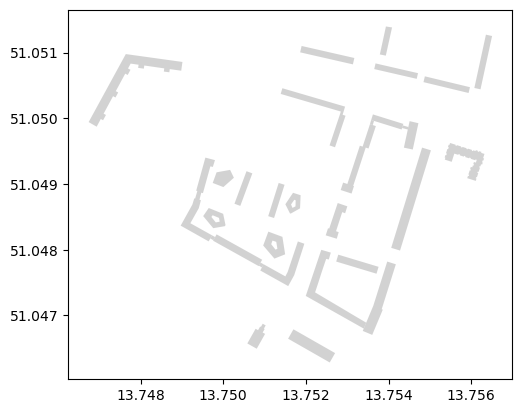

In [129]:
residential_build.plot(color='silver', alpha=0.7)
# residential_build.head()


In [175]:
floor_area_normalize =15000
areas = areas.to_crs(4326)
areas_gdf = areas.to_frame(name='geometry')
# print(areas_gdf)
# perform spatial join between the two dataframes based on their spatial relationship
buildings_by_area = gpd.sjoin(residential_build, areas_gdf, predicate='intersects')
# buildings_by_area.plot(color='silver', alpha=0.7)

buildings_by_area_proj = ox.project_gdf(buildings_by_area)
buildings_by_area['building_area'] = buildings_by_area_proj.geometry.area
del buildings_by_area_proj

buildings_by_area["floor_nr"] = buildings_by_area["building:levels"].fillna("1")
buildings_by_area["floor_area"] = buildings_by_area['building_area'] * \
                                    np.asarray(buildings_by_area["floor_nr"], dtype=int)

# # group the buildings by the area of the same street and sum the areas
floor_area = buildings_by_area.groupby("index_right")["floor_area"].sum()/floor_area_normalize
# floor_area /= floor_area_normalize
bikes_residence_copy = bikes_residence_copy.merge(floor_area, left_index=True, right_index=True)
print(bikes_residence_copy)



    occurrence                                           geometry  floor_area
60     204.000  LINESTRING (227571.262 10362.224, 227660.507 1...    0.324740
73      29.000  LINESTRING (227767.277 10397.518, 227773.953 1...    2.505042
74      31.375  LINESTRING (227767.277 10397.518, 227787.696 1...    2.175511
83      14.400  LINESTRING (227923.962 10356.661, 227974.947 1...    1.581968


In [232]:
areas = bikes_residence_copy.geometry.buffer(am_buffer_range) #meter
areas.explore()

In [235]:
amenity = ox.geometries_from_bbox(
    coords["ne"][0], coords["se"][0], coords["se"][1], coords["sw"][1],
    amenity_tags)
# edu_building = ox.geometries_from_bbox(
#     coords["ne"][0], coords["se"][0], coords["se"][1], coords["sw"][1],
#     education_tags) 
 

In [236]:
amenity.explore()

In [237]:
def assign_amenity(row):
    shop_dict ={
        "department_store":["department_store","mall"],
        "supermarket":["general","supermarket","wholesale"],
        "kiosk":["kiosk","convenience"],
        "variety_store":["variety_store"],
        "foodstore":["health_food","greengrocer","butcher"],
        "bakery":["pastry","bakery"],
        "ice_cream":["ice_cream"],
        "bookstore":["books","stationery"],
        "ticket":["ticket"],
        "copyshop":["copyshop"],
        "fashion":["bag","clothes","shoes","cosmetics"],
        "DIY":["doityourself","hardware"],
        "houseware":["houseware"],
        "furniture":["bed","carpet","furniture","interior_decoration"],
        "electronics":["computer","electronics"],
        "sportstore":["outdoor","sports"],
        "florist":["florist","garden_centre"],
        "laundry":["laundry"],
        "petstore":["pet"],
        "toystore":["toys"]
    }
    amenity_dict = {
        "cafe":["biergarten", "cafe", "fast_food", "food_court", "ice_cream","bar"],
        "restaurant":["restaurant"],
        "pub":["pub", "nightclub"],
        "theatre":["theatre"],
        "cinema":["cinema"],
        "market":["marketplace"],
        "place_of_worship":["place_of_worship"],
        "bank":["bank"],
        "pharmacy":["pharmacy"],
        "chemist":["chemist"],
        "post_office":["post_office"],
        "townhall":["townhall"],
        "library":["library"],
        "kindergarten":["kindergarten"],
        "school":["school"],
        "college":["college"]
    }
    leisure_dict = {
        "park":["park", "playground"],
        "stadium":["stadium"],
        "sportplace":["fitness_centre","fitness_station","pitch", "sports_centre"]
    }
    building_dict ={
        "university": ["university"]
    }
    
    for key, value in shop_dict.items():
        if row['shop'] in value:
            return key
    for key, value in amenity_dict.items():
        if row['amenity'] in value:
            return key
    for key, value in leisure_dict.items():
        if row['leisure'] in value:
            return key 
    for key, value in building_dict.items():
        if row['building'] in value:
            return key    
    print("no amenity found")
    return None               

In [259]:
areas = areas.to_crs(4326)
areas_gdf = areas.to_frame(name='geometry')
shops = amenity[["geometry","amenity","shop","leisure","building"]]
joined_data = gpd.sjoin(areas_gdf, shops, predicate="intersects")
amenity_array = joined_data.apply(assign_amenity, axis=1)
counts = amenity_array.groupby(level=0).value_counts().unstack(fill_value=0)

new_cols = [
    "department_store","supermarket","kiosk","variety_store","foodstore",
    "bakery","ice_cream","bookstore","ticket","copyshop","fashion","DIY",
    "houseware","furniture","electronics","sportstore","florist","laundry",
    "petstore","toystore","cafe","restaurant","pub","theatre","cinema",
    "market","place_of_worship","bank","pharmacy","chemist","post_office",
    "townhall","library","kindergarten","school", "college","park","stadium",
    "sportplace","university"
]
for col in new_cols:
    bikes_residence_copy = bikes_residence_copy.assign(**{col: 0})

bikes_residence_copy.update(counts)
# print(counts)
# print(bikes_residence_copy)
# joined_data = shops.groupby(["amenity","shop"]).size()
# print(shops[["amenity","shop","leisure"]])
# print(joined_data[["amenity","shop","leisure"]])
#find duplicate

    bakery  cafe  park  post_office  pub  restaurant  school  sportplace  \
60       1     2     0            0    1           0       0           1   
73       0     0     2            0    0           0       2           0   
74       0     1     1            0    0           0       0           0   
83       0     0     0            1    0           1       2           1   

    supermarket  
60            0  
73            0  
74            0  
83            1  
    occurrence                                           geometry  \
60     204.000  LINESTRING (227571.262 10362.224, 227660.507 1...   
73      29.000  LINESTRING (227767.277 10397.518, 227773.953 1...   
74      31.375  LINESTRING (227767.277 10397.518, 227787.696 1...   
83      14.400  LINESTRING (227923.962 10356.661, 227974.947 1...   

    department_store  supermarket  kiosk  variety_store  foodstore  bakery  \
60                 0            0      0              0          0       1   
73                 0       